<a href="https://colab.research.google.com/github/vikramkrishnan9885/MyColab/blob/master/BinaryImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps (LEPBLOTD)

1. Load Data
2. Explore data
3. Preprocessing Data
4. Building the model
5. defining the Loss model
6. defining Optimizer
7. Train and evaluating the model
8. Deploying the model

# 1. Load data

## From local

In [0]:
#from google.colab import files
#uploaded = files.upload()

## From kaggle
This did not work in our case because our data comes from a competition not a data set

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
%cd /content/drive/My Drive/
%pwd

/content/drive/My Drive


'/content/drive/My Drive'

In [15]:
# Run the following code to provide the config path to kaggle.json
import os

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

#changing the working directory
#Check the present working directory using pwd command
%cd /content/drive/My Drive/Kaggle
%pwd

/content/drive/My Drive/Kaggle


'/content/drive/My Drive/Kaggle'

In [16]:
!kaggle datasets download -d datasnaek/youtube-new

youtube-new.zip: Skipping, found more recently modified local copy (use --force to force download)


## Using google drive

In [0]:
!unzip '/content/drive/My Drive/Kaggle/histopathologic-cancer-detection.zip'

# 2. Explore data

In [0]:
import pandas as pd

## Read labels

First, we loaded the labels as a DataFrame using pandas. The DataFrame has two columns: id and label. The id column refers to the image filename, while the label column shows whether the image is normal (label=0) or malignant (label=1).

In [15]:
path2csv = 'train_labels.csv'
labels_df=pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Counts

In step 2, we counted the number of normal and malignant images. As we saw, around 59% of the images were normal and 41% were malignant. The histogram in step 3 shows somewhat imbalanced data.

In [16]:
labels_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

## Histogram of labels

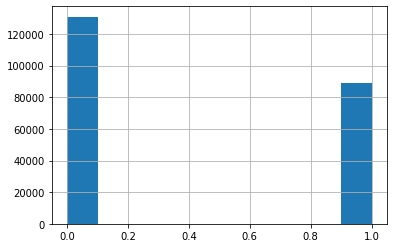

In [17]:
%matplotlib inline
labels_df['label'].hist()

## Let's visualize a few images that have a positive label. 

A positive label shows that the center 32 x 32 region of an image contains at least one pixel of tumor tissue.

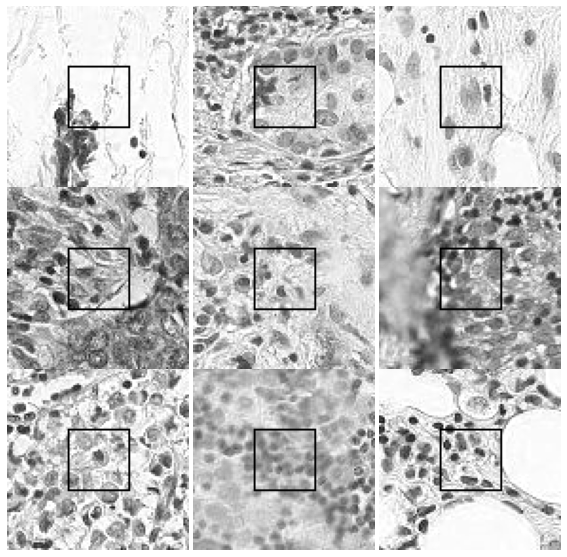

In [18]:
# First, we import the required packages:
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

# data is stored here
path2train="train/"

# show images in gray-scale, if you want color change it to True
color=False

# get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

# Next, we set the figure sizes
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3

# Next, we display the images
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train , id_ +'.tif')
 
    # load image
    img = Image.open(full_filenames)

    # draw a 32*32 rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)),outline="green")

    plt.subplot(nrows, ncols, i+1) 
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0],cmap="gray")
    plt.axis('off')

In [19]:
# Let's also get the image's shape and minimum and maximum pixel values
print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img), np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


# 3. Preprocessing data

## Creating a custom dataset

A traditional method for working with a dataset would be to load all images into NumPy arrays. Since we are dealing with a relatively large dataset, this would be a waste of our computer resources. If you are short on RAM, this would be impossible. Luckily, PyTorch has a powerful tool to handle large datasets.

We can create a custom Dataset class by subclassing the PyTorch Dataset class. When creating a custom Dataset class, make sure to define two essential functions: `__len__` and `__getitem__`. The `__len__` function returns the dataset's length. This function is callable with the Python len function. The `__getitem__` function returns an image at the specified index.

In [20]:
# First, we will load the required packages.
import torch
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

# Don't forget to fix the random seed for reproducibility:
# fix torch random seed
torch.manual_seed(0)

class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):      
    
        # path to images
        path2data=os.path.join(data_dir,data_type)

        # get list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        path2csvLabels=os.path.join(data_dir,"train_labels.csv")
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform
      
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

# Next, we will define a simple transformation that only converts a PIL image into PyTorch tensors.
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

# Then, we will define an object of the custom dataset for the train folder:
data_dir = "./"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

# Next, we will load an image using the custom dataset:
# load an image
img,label=histo_dataset[9]
print(img.shape,torch.min(img),torch.max(img))

220025
torch.Size([3, 96, 96]) tensor(0.0431) tensor(1.)


In [21]:
# We will split the dataset into training and validation and 
# then display a few sample images from each dataset. Let's get started:

# Let's split histo_dataset:
from torch.utils.data import random_split

len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [22]:
# Then, we can get an image from the training dataset:
for x,y in train_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 1


In [23]:
# We will also get an image from the validation dataset:
for x,y in val_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 0


image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


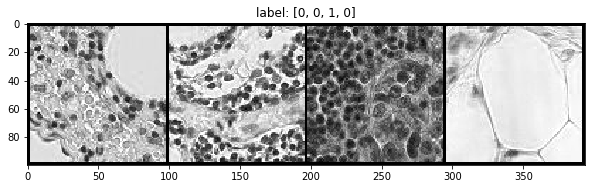

In [24]:
# Let's display a few samples from train_ds
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

# Define a helper function to show an image
def show(img,y,color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))

# Create a grid of sample images
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ds[i][0] for i in rnd_inds]
y_grid_train=[train_ds[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

# Call the helper function to display the grid
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train,y_grid_train)

image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


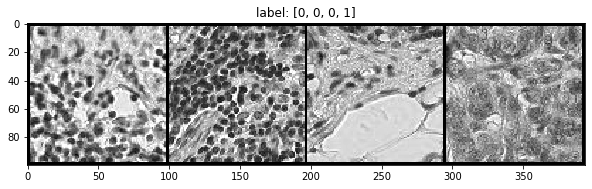

In [25]:
# We can also show a few samples from val_ds
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ds[i][0] for i in range(grid_size)]
y_grid_val=[val_ds[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

show(x_grid_val,y_grid_val)


## Transforming data

In [0]:
# First, let's define the following transformations for the training dataset:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()]
)

In [0]:
# For the validation dataset, we don't need any augmentation. 
# So, we only convert the images into tensors in the transforms function:
val_transformer = transforms.Compose([transforms.ToTensor()])

In [0]:
# After defining the transformations, we overwrite the transform functions of train_ds and val_ds:
# overwrite the transform functions
train_ds.transform=train_transformer
val_ds.transform=val_transformer

## Creating dataloaders
We are ready to create a PyTorch dataloader. If we do not use dataloaders, we have to write code to loop over datasets and extract a data batch. 

In step 1, when defining a PyTorch Dataloader, we need to define the batch size. The batch size determines the number of images to be extracted from the dataset in each iteration. The typical values of the batch size for classification tasks are in the range of [8-128]. Also, note that we do not need to shuffle the validation data during evaluation.

If your computer or the GPU device on your computer does not have enough memory, you can reduce the batch size to avoid memory errors.
When iterating over a dataloader, it will automatically extract batches of data from the dataset. As seen in step 2, for the train dataloader, we extracted batches of images that were 32 in size. This was 64 for the validation dataloader since we set the batch size to 64.

In [30]:
# First, let's define two dataloaders for the datasets:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

# Then, we get a data batch from the training dataloader:
# extract a batch from training data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

# Next, we get a data batch from the validation dataloader:
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 96, 96])
torch.Size([32])
torch.Size([64, 3, 96, 96])
torch.Size([64])


# 4. Building the model

## Set baselines

In step 1, we created dumb baselines. We should always establish a baseline before moving forward with complex models. This will help us find out how well we are performing. We can create dumb baselines by creating random predictions, all-zero predictions, or all-one predictions. Let's create simple baselines using these predictions. It is interesting to see that we can get an accuracy of 0.60 with dumb predictions.

In [31]:
#dumb baselines
# get labels for validation dataset
y_val=[y for _,y in val_ds]    

# Next, we will define a function to calculate the classification accuracy:
def accuracy(labels, out):
    return np.sum(out==labels)/float(len(labels))

# Then, we will calculate a dumb baseline for all-zero predictions:
# accuracy all zero predictions
acc_all_zeros=accuracy(y_val,np.zeros_like(y_val))

# Next, we will calculate a dumb baseline for all-one predictions:
# accuracy all ones predictions
acc_all_ones=accuracy(y_val,np.ones_like(y_val))

# Next, we will calculate a dumb baseline for random predictions:
# accuracy random predictions
acc_random=accuracy(y_val,np.random.randint(2,size=len(y_val)))

print("accuracy random prediction: %.2f" %acc_random)
print("accuracy all zero prediction: %.2f" %acc_all_zeros)
print("accuracy all one prediction: %.2f" %acc_all_ones)

accuracy random prediction: 0.49
accuracy all zero prediction: 0.60
accuracy all one prediction: 0.40


In step 2, we developed findConv2DOutShape to automatically compute the output size of a CNN and pooling layer. The inputs to this function are:

H_in: an integer representing the height of input data
W_in: an integer representing the width of input data
conv: an object of the CNN layer
pool: an integer representing the pooling size and default to 2
The function receives the input size, H_in, W_in, and  conv layer and provides the output size, H_out, W_out. The formula to compute the output size is given in the following link: https://pytorch.org/docs/stable/nn.html


In [32]:
# find Output size

import torch.nn as nn

# Then, we'll define the helper function:
def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)


# example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w=findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


### Class definition
* In step 3, we implemented the CNN model using the nn.Module class. 
* In the `__init__` function, we define the layers of the model. 
* We provide the model parameters as a Python dictionary to this function. 
* We recommend using variables for the model parameters and a dictionary to define them outside the class. 
* This way, in the case of parameter changes, we do not have to make changes inside the Net class. 
* This will also make future hyperparameter searches easier.

### Forward algorithm
* In the forward function, we use the defined layers to outline the model. 
* We use nn.Conv2d and nn.Linear to define the CNN and fully connected layers, respectively. 
* The pooling layers, activations, and dropout layers act like functions and can be defined using nn.functional. 
* We do not need to define these layers in the `__init__` function.

### Layers in class definition
#### CNN layers
* Each layer needs specific arguments to be defined. 
* For most layers, it is important to specify the number of inputs and outputs of the layer.
*  For instance, the first CNN layer has C_in=3 channels as input and init_f=8 filters as output, as defined in the following code:
```
self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
``` 
* Similarly, the second CNN layer receives `init_f=8` channels as input and `2*init_f=16` channels as output. 
* Thus, by providing the number of output channels of the previous layer as the number of input channels to the next layer, we can define each layer. 
* However, this becomes tricky when it comes to nn.Linear layers. 
* The linear layer accepts a 2D tensor. That is why we need the view method in the forward function to reshape the 4D tensor into a 2D tensor:
```
# flatten/reshape
x = x.view(-1, self.num_flatten)
```
* How do we get the value of self.num_flatten? Well, PyTorch does not automatically calculate this value. It is our duty to find this value and provide it to the linear layer.
* One approach would be to print (x.size()) to get the output shape of each layer.
#### Helper function
* The other option is using the findConv2DOutShape function. The output size of the fourth CNN layer (together with the pooling layer) is h,w and there are `8*init_f` output channels. Therefore, after flattening, we get `self.num_flatten=h*w*8*init_f`.
#### Dropout
* We also added a dropout layer before the output layer to reduce the overfitting problem in deep learning models. 
* Notice that we set the `training = self.training` argument in the `F.dropout` function. 
  * The self.training parameter is automatically set to `True` during training and `False` at evaluation. This will bypass the dropout layer at the deployment time.
* The dropout layer is only applied during training. At deployment, the dropout layer should be deactivated. 
#### Softmax
The last layer is F.log_softmax(x, dim=1) (with two outputs), which is equivalent to . Keep in mind that if we want to get the output probability value, we need to use the exponential operation.


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [35]:
# dict to define model parameters
params_model={
        "input_shape": (3,96,96),
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2,
            }


# create model
cnn_model = Net(params_model)


# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device)


print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [36]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


# 5. Loss function

The standard loss function for classification tasks is cross-entropy loss or logloss. However, when defining the loss function, we need to consider the number of model outputs and their activation functions. For binary classification tasks, we can choose one or two outputs.

| Output Activation | Number of Outputs | Loss Function |
|----|----|---|
| None| 1 | nn.BCEWithLogitsLoss |
| Sigmoid | 1 | nn.BCELoss |
| None | 2 | nn.CrossEntropyLoss |
| log_softmax | 2 | nn.NLLLoss |


We recommend using the log_softmax function as it is easier to expand to multi-class classification.

In [37]:
# We use log_softmax as the output and nn.NLLLoss as the negative log-likelihood loss. 
# An important argument in defining the loss function to pay attention to is the reduction, 
# which specifies the reduction to apply to the output. 
# There are three options to choose from: none, sum, and mean. 
# We choose reduction=sum so that the output loss will be summed. 
# Since we will process the data in batches, this will return the sum of loss values per batch of data.
loss_func = nn.NLLLoss(reduction="sum")

# fixed random seed
torch.manual_seed(0)

n,c=8,2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out=ls_F(y)
print(y_out.shape)

target = torch.randint(c,size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())
torch.Size([8, 2])
torch.Size([8])

loss.backward()
print (y.data)

torch.Size([8, 2])
torch.Size([8])
5.266995429992676
tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


# 6. Defining the optimizer
* The torch.optim package provides the implementation of common optimizers. 
* The optimizer will hold the current state and will update the parameters based on the computed gradients. 
* For binary classification tasks, SGD and Adam optimizers are used the most.

## Learning schedules
* Another helpful tool in the torch.optim package is learning schedules. 
* Learning schedules are useful tools for automatically adjusting the learning rate during training to improve model performance. 

In [39]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In step 1, we defined the Adam optimizer. The important parameters of the optimizer class are the model's parameters and the learning rate. cnn_model.parameters() returns an iterator over module parameters that are passed to the optimizer. The learning rate will determine the amount to update by. In PyTorch, we can set a different learning rate per layer, but in this chapter, we'll choose to set one learning rate for all the layers. 

In step 2, we developed a helper function that returns the current value of the learning rate.

In [40]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)


for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


In step 3, we used the ReduceLROnPlateau method from the torch.optim.lr_scheduler package. This scheduler reads a metric quantity and if no improvement is seen for a patience number of epochs, the learning rate is reduced by a factor of 0.5. The mode argument defines whether the metric quantity is increasing or decreasing during training. For instance, if we monitor the loss value, we set mode='min'. If we monitor the accuracy, we should set mode='max'. 

In step 4, we showed you how the learning rate schedule works by passing it a constant value during a loop. As we saw, after every 20 iterations, the scheduler reduces the learning rate by half.

# 7. Train and evaluate

## First, let's develop a helper function to count the number of correct predictions per data batch:


In [0]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

## Then, we will develop a helper function to compute the loss value per batch of data:

In [0]:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

## Next, we develop a helper function to compute the loss value and the performance metric for the entire dataset, also called an epoch

In [0]:
# define device as a global variable
device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

## train_val function

In [0]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [46]:
n,c=8,2
output = torch.randn(n, c, requires_grad=True)
print (output)
print(output.shape)

#target = torch.randint(c,size=(n,))
target = torch.ones(n,dtype=torch.long)
print(target.shape)

metrics_batch(output,target)

tensor([[ 0.4681, -0.1577],
        [ 1.4437,  0.2660],
        [ 0.1665,  0.8744],
        [-0.1435, -0.1116],
        [ 0.9318,  1.2590],
        [ 2.0050,  0.0537],
        [ 0.6181, -0.4128],
        [-0.8411, -2.3160]], requires_grad=True)
torch.Size([8, 2])
torch.Size([8])


3

### Sanity check:True

In [48]:
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
  "num_epochs": 100,  
  "optimizer": opt,
  "loss_func": loss_func,
  "train_dl": train_dl,
  "val_dl": val_dl,
  "sanity_check": True,
  "lr_scheduler": lr_scheduler,
  "path2weights": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 0.000124, dev loss: 0.000998, accuracy: 0.08
----------
Epoch 1/99, current lr=0.0003
Copied best model weights!
train loss: 0.000125, dev loss: 0.000997, accuracy: 0.08
----------
Epoch 2/99, current lr=0.0003
Copied best model weights!
train loss: 0.000122, dev loss: 0.000996, accuracy: 0.08
----------
Epoch 3/99, current lr=0.0003
train loss: 0.000127, dev loss: 0.000996, accuracy: 0.08
----------
Epoch 4/99, current lr=0.0003
Copied best model weights!
train loss: 0.000119, dev loss: 0.000995, accuracy: 0.08
----------
Epoch 5/99, current lr=0.0003
Copied best model weights!
train loss: 0.000128, dev loss: 0.000994, accuracy: 0.08
----------
Epoch 6/99, current lr=0.0003
train loss: 0.000122, dev loss: 0.000995, accuracy: 0.08
----------
Epoch 7/99, current lr=0.0003
Copied best model weights!
train loss: 0.000118, dev loss: 0.000991, accuracy: 0.08
----------
Epoch 8/99, current lr=0.0003
train loss: 0.000120, de

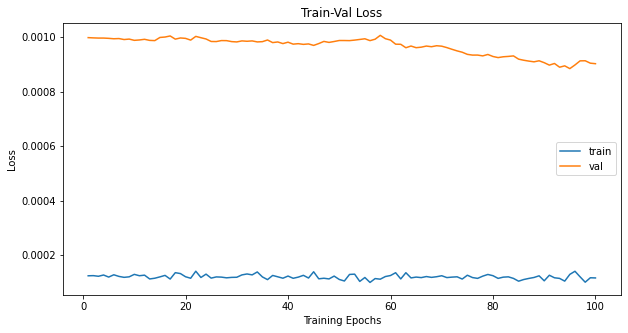

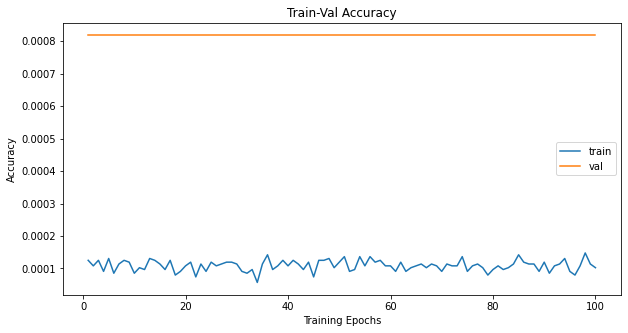

In [49]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

### Sanity check: False

In [50]:
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
  "num_epochs": 2,
  "optimizer": opt,
  "loss_func": loss_func,
  "train_dl": train_dl,
  "val_dl": val_dl,
  "sanity_check": False,
  "lr_scheduler": lr_scheduler,
  "path2weights": "weights1.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

Epoch 0/1, current lr=0.0003
Copied best model weights!
train loss: 0.447653, dev loss: 0.394512, accuracy: 82.26
----------
Epoch 1/1, current lr=0.0003
Copied best model weights!
train loss: 0.370977, dev loss: 0.338917, accuracy: 85.32
----------


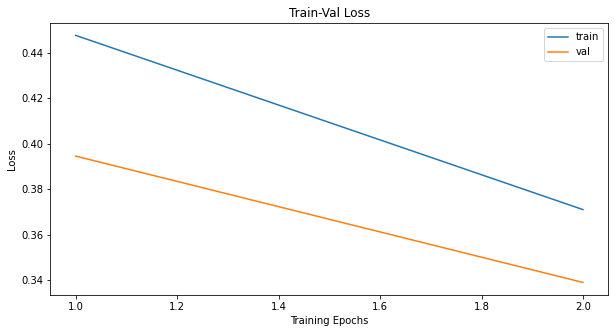

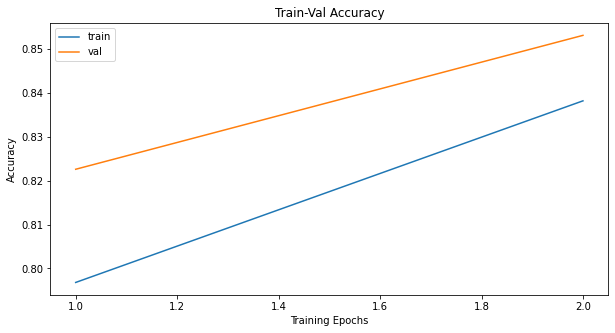

In [51]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()